Fit linear models predicting female behavior from surrogate neural activity.

In [1]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import linear_model
import sys

from disp import set_plot
from my_torch import skl_fit_ridge

cc = np.concatenate

STRAINS = ['NM91', 'ZH23']
PTRAIN = .8
NSPLIT = 30
NH = 17  # num filter basis functions

BASIS = 'rc'
# BASIS = 'rect'

TARGS = ['FFV_MN_60', 'FFV']
# TARGS = ['FLS_MN_60', 'FLS']

FIT_LIN = skl_fit_ridge

ALPHA = 10
FIT_KWARGS = {'alpha': ALPHA}

In [4]:
FSTRAIN = 'data/simple/strains.csv'

FPFX_NEUR_BHV = f'data/simple/mlv/lin_filter/{BASIS}_lin/{BASIS}_lin'
FPFX_BHV_XTD = f'data/simple/behav_xtd/behav_xtd'

FSAVE = f'data/simple/mlv/lin_filter/{BASIS}_lin_{"_".join(STRAINS).lower()}_{TARGS[0].lower()}_ridge_alpha_{ALPHA}.npy'

COLS_USE = [f'S_{ch}' for ch in range(NH)] + [f'P_{ch}' for ch in range(NH)]

MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

NTR = MSTRAIN.sum()
NTRAIN = int(round(PTRAIN*NTR))

In [5]:
# fit regression models
rslts = []
for csplit in range(NSPLIT):
    print(f'Split {csplit}')
    irnd = np.random.permutation(NTR)
    idxs_train = ISTRAIN[irnd[:NTRAIN]]
    idxs_test = ISTRAIN[irnd[NTRAIN:]]
    if csplit < 2:
        rslt = FIT_LIN([FPFX_NEUR_BHV, FPFX_BHV_XTD], COLS_USE, TARGS, idxs_train, idxs_test, return_y=True, **FIT_KWARGS)
    else:
        rslt = FIT_LIN([FPFX_NEUR_BHV, FPFX_BHV_XTD], COLS_USE, TARGS, idxs_train, idxs_test, return_y=False, **FIT_KWARGS)
    rslts.append(rslt)
    

In [6]:
# save r2, weights, and example predictions
save_data = {
    'r2_train': {targ: np.array([rslt.r2_train[targ] for rslt in rslts]) for targ in TARGS},
    'r2_test': {targ: np.array([rslt.r2_test[targ] for rslt in rslts]) for targ in TARGS},
    'w': {targ: np.array([rslt.w[targ] for rslt in rslts]) for targ in TARGS},
    'ys_train': {targ: [rslt.ys_train[targ] for rslt in rslts[:2]] for targ in TARGS},
    'ys_test': {targ: [rslt.ys_test[targ] for rslt in rslts[:2]] for targ in TARGS},
    'y_hats_train': {targ: [rslt.y_hats_train[targ] for rslt in rslts[:2]] for targ in TARGS},
    'y_hats_test': {targ: [rslt.y_hats_test[targ] for rslt in rslts[:2]] for targ in TARGS},
    'targs': TARGS,
    'fit_fn': FIT_LIN.__name__,
    'fit_kwargs': FIT_KWARGS,
    'ntr': NTR,
    'nsplit': NSPLIT,
    'nr': len(COLS_USE)
}

np.save(FSAVE, np.array([save_data]))

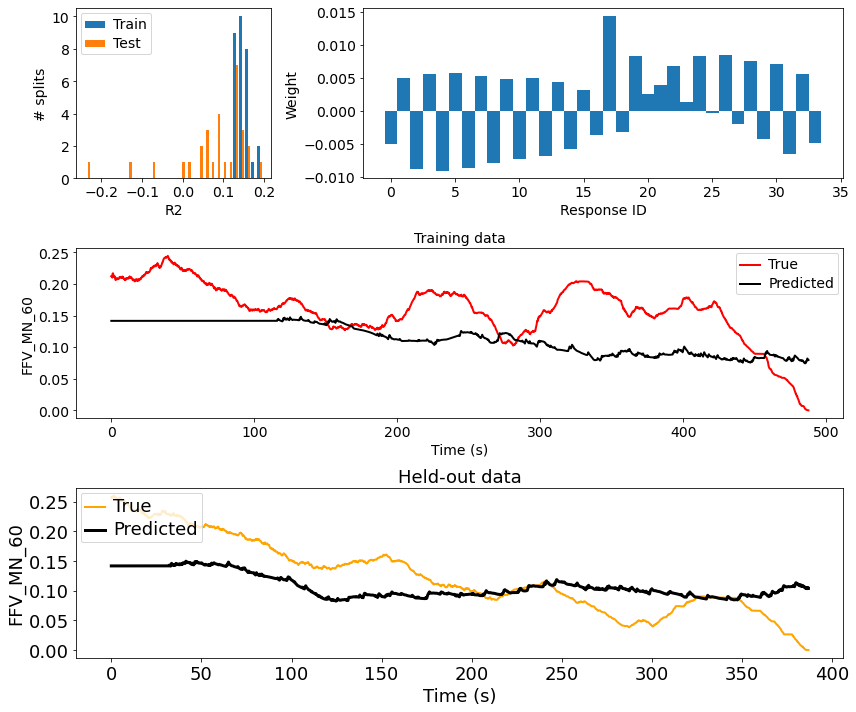

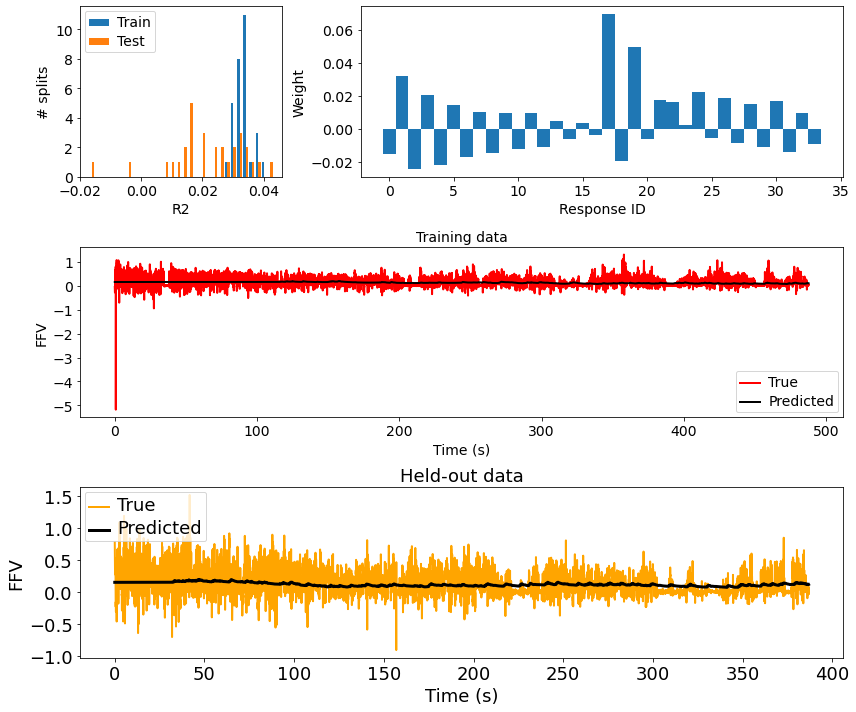

In [7]:
TRAIN_IDX_PLOT = 12
TEST_IDX_PLOT = 16

data = np.load(FSAVE, allow_pickle=True)[0]

for targ in TARGS:
    gs = gridspec.GridSpec(3, 3)

    fig = plt.figure(figsize=(12, 10), tight_layout=True)
    axs = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1:]), fig.add_subplot(gs[1, :]), fig.add_subplot(gs[2, :])]

    axs[0].hist(np.transpose([data['r2_train'][targ], data['r2_test'][targ]]), bins=30)
    axs[0].legend(['Train', 'Test'])
    set_plot(axs[0], x_label='R2', y_label='# splits', font_size=14)

    axs[1].bar(np.arange(data['w'][targ].shape[1]), np.mean(data['w'][targ], axis=0), width=1)
    set_plot(axs[1], x_label='Response ID', y_label='Weight', font_size=14)

    axs[2].plot(np.arange(len(data['ys_train'][targ][0][TRAIN_IDX_PLOT]))/30.03, data['ys_train'][targ][0][TRAIN_IDX_PLOT], c='r', lw=2)
    axs[2].plot(np.arange(len(data['y_hats_train'][targ][0][TRAIN_IDX_PLOT]))/30.03, data['y_hats_train'][targ][0][TRAIN_IDX_PLOT], c='k', lw=2)
    axs[2].legend(['True', 'Predicted'])
    set_plot(axs[2], x_label='Time (s)', y_label=targ, title='Training data', font_size=14)

    axs[3].plot(np.arange(len(data['ys_test'][targ][0][TEST_IDX_PLOT]))/30.03, data['ys_test'][targ][0][TEST_IDX_PLOT], c='orange', lw=2)
    axs[3].plot(np.arange(len(data['y_hats_test'][targ][0][TEST_IDX_PLOT]))/30.03, data['y_hats_test'][targ][0][TEST_IDX_PLOT], c='k', lw=3)
    axs[3].legend(['True', 'Predicted'], loc='upper left')
    set_plot(axs[3], x_label='Time (s)', y_label=targ, title='Held-out data', font_size=18)

# Show filter reconstructions

In [9]:
FPS = 30.03
DT = 1/FPS
MAX_T = 120  # max look-back window
T_H = np.arange(0, MAX_T, DT)

## Stretched rectangular basis

17 filters


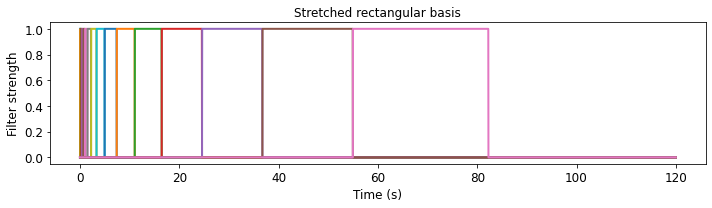

In [10]:
NDT_0 = 1  # width of closest filter
STRETCH = 1.5  # stretch factor relative to distance
hs_rect = []

istart = 0
istop = 0
ndt = NDT_0
while (istart+ndt)*DT < MAX_T:
    
    h_rect = np.zeros(T_H.shape)
    h_rect[istart:istart+ndt] = 1/(ndt*DT)
    hs_rect.append(h_rect.copy())
    
    istart = istart+ndt+1
    ndt = int(round(STRETCH*ndt))
    
hs_rect = np.array(hs_rect)

fig, ax = plt.subplots(1, 1, figsize=(10, 3), tight_layout=True)
for h_rect in hs_rect:
    ax.plot(T_H, h_rect/h_rect.max(), lw=2)
    
set_plot(ax, x_label='Time (s)', y_label='Filter strength', title='Stretched rectangular basis', font_size=12)
print(f'{len(hs_rect)} filters')

## Raised cosine basis

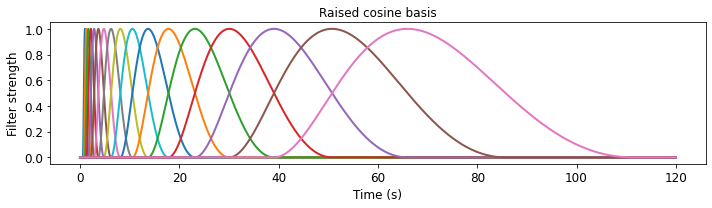

In [11]:
hs_rc = []
a = 6
c = 0
phis = np.arange(len(hs_rect)) * np.pi/2

for ch, phi in enumerate(phis):
    h_rc = .5*np.cos(a*np.log(T_H + c) - phi) + .5
    mt_zero = (a*np.log(T_H + c) < (phi-np.pi)) | (a*np.log(T_H + c) >= (phi+np.pi))
    h_rc[mt_zero] = 0
    hs_rc.append(h_rc)
    
hs_rc = np.array(hs_rc)
    
fig, ax = plt.subplots(1, 1, figsize=(10, 3), tight_layout=True)
for h_rc in hs_rc:
    ax.plot(T_H, h_rc/h_rc.max(), lw=2)
    
set_plot(ax, x_label='Time (s)', y_label='Filter strength', title='Raised cosine basis', font_size=12)

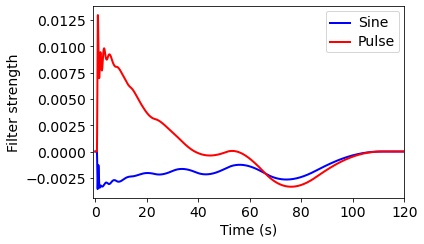

In [19]:
if BASIS == 'rect':
    hs = hs_rect
elif BASIS == 'rc':
    hs = hs_rc
    
fig, ax = plt.subplots(1, 1, figsize=(6, 3.5), tight_layout=True)
# sine filter
w_s = data['w']['FFV_MN_60'].mean(0)[:len(hs)]
h_s = w_s@hs

w_p = data['w']['FFV_MN_60'].mean(0)[len(hs):]
h_p = w_p@hs

ax.plot(T_H, h_s, c='b', lw=2)
ax.plot(T_H, h_p, c='r', lw=2)

ax.set_xlim(-1, 120)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Filter strength')
ax.legend(['Sine', 'Pulse'])

set_plot(ax, font_size=14)